In [20]:
import pandas as pd
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [21]:
yf.Tickers(['VIX', '^TYX']).history(period='5y')

[*********************100%***********************]  2 of 2 completed


Close        Dividends              High         \
                    VIX   ^TYX       VIX ^TYX          VIX   ^TYX   
Date                                                                
2016-08-22  5809.520020    NaN       0.0  NaN  6095.240234    NaN   
2016-08-23  5809.520020  2.236       0.0  0.0  5904.759766  2.247   
2016-08-24  5809.520020  2.243       0.0  0.0  6000.000000  2.257   
2016-08-25  5809.520020  2.264       0.0  0.0  5904.759766  2.271   
2016-08-26  6095.240234  2.296       0.0  0.0  6190.479980  2.296   
...                 ...    ...       ...  ...          ...    ...   
2021-08-16          NaN  1.924       NaN  0.0          NaN  1.941   
2021-08-17          NaN  1.919       NaN  0.0          NaN  1.936   
2021-08-18          NaN  1.914       NaN  0.0          NaN  1.939   
2021-08-19          NaN  1.876       NaN  0.0          NaN  1.892   
2021-08-20          NaN  1.874       NaN  0.0          NaN  1.882   

                    Low                Open        Stock Splits       \
                    VIX   ^TYX          VIX   ^TYX          VIX ^TYX   
Date                                                                   
2016-08-22  5809.520020    NaN  6095.240234    NaN          0.0  NaN   
2016-08-23  5809.520020  2.213  5809.520020  2.240          0.0  0.0   
2016-08-24  5809.520020  2.227  5809.520020  2.230          0.0  0.0   
2016-08-25  5714.290039  2.236  5809.520020  2.241          0.0  0.0   
2016-08-26  5809.520020  2.210  5809.520020  2.251          0.0  0.0   
...                 ...    ...          ...    ...          ...  ...   
2021-08-16          NaN  1.887          NaN  1.932          NaN  0.0   
2021-08-17          NaN  1.892          NaN  1.896          NaN  0.0   
2021-08-18          NaN  1.905          NaN  1.938          NaN  0.0   
2021-08-19          NaN  1.864          NaN  1.870          NaN  0.0   
2021-08-20          NaN  1.853          NaN  1.856          NaN  0.0   

              Volume       
                 VIX ^TYX  
Date                       
2016-08-22  783438.0  NaN  
2016-08-23  419550.0  0.0  
2016-08-24  371564.0  0.0  
2016-08-25  279626.0  0.0  
2016-08-26  819444.0  0.0  
...              ...  ...  
2021-08-16       NaN  0.0  
2021-08-17       NaN  0.0  
2021-08-18       NaN  0.0  
2021-08-19       NaN  0.0  
2021-08-20       NaN  0.0  

[1251 rows x 14 columns]

F
Bin Thresholds:  [-10, -0.1, 0.1, 10]


<AxesSubplot:>

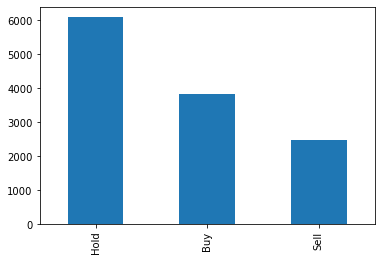

In [22]:
def generate_features(ticker, period_range="Max", buy_sell_threshold =[-0.1,0.1], gain_window = 60):
    stk_data = yf.Ticker(ticker)
    print(stk_data.ticker)
    df_data = stk_data.history(period=period_range)


    df_data['Week'] = df_data.index.isocalendar().week
    df_data['Day'] = df_data.index.isocalendar().day

    df_data['PrevDayChng'] = df_data['Close'].pct_change(periods=1).shift(1).fillna(0)
    df_data['Var'] = df_data.Close.rolling(10).var()
    df_data['Var'] = df_data['Var'].fillna(df_data['Var'].mean())

    df_data['52Wk_High'] = df_data.Close.rolling(260, min_periods=1).max()
    df_data['52Wk_Low'] = df_data.Close.rolling(260, min_periods=1).min()

    df_data['EMA5'] = df_data.Close.ewm(span=5, adjust=False).mean()
    df_data['EMA12'] = df_data.Close.ewm(span=12, adjust=False).mean()
    df_data['EMA26'] = df_data.Close.ewm(span=26, adjust=False).mean()
    df_data['MACD'] = df_data.EMA12-df_data.EMA26
    df_data['Signal'] = df_data.MACD.ewm(span=9, adjust=False).mean()
    df_data['MACD_Trigger'] = df_data.MACD - df_data.Signal

    # % Change in 2 weeks
    df_data['Short_Gain'] = df_data.Close.pct_change(10).shift(-10)
    df_data['Short_Gain'] = df_data['Short_Gain'].fillna(df_data['Short_Gain'].mean())

    # % change in long-term
    df_data['Long_Gain'] = df_data.Close.pct_change(gain_window).shift(-gain_window)
    df_data['Long_Gain'] = df_data['Long_Gain'].fillna(df_data['Long_Gain'].mean())

    bins=[-10]+buy_sell_threshold+[10]
    print("Bin Thresholds: ", bins)
    df_data['Rating'] = pd.cut(df_data.Long_Gain, bins=bins, labels=['Sell', 'Hold', 'Buy',])

    return df_data

df_data = generate_features('F')
df_data

df_data.Rating.value_counts().plot(kind='bar')


<AxesSubplot:xlabel='Date', ylabel='Close'>

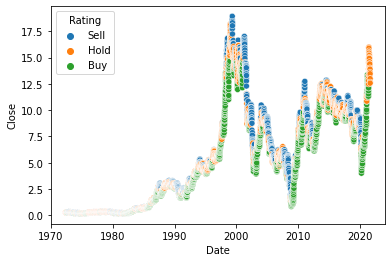

In [23]:
sns.scatterplot(data=df_data, x=df_data.index, y='Close', hue='Rating')

In [24]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12414 entries, 1972-06-01 to 2021-08-20
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Open          12414 non-null  float64 
 1   High          12414 non-null  float64 
 2   Low           12414 non-null  float64 
 3   Close         12414 non-null  float64 
 4   Volume        12414 non-null  int64   
 5   Dividends     12414 non-null  float64 
 6   Stock Splits  12414 non-null  float64 
 7   Week          12414 non-null  UInt32  
 8   Day           12414 non-null  UInt32  
 9   PrevDayChng   12414 non-null  float64 
 10  Var           12414 non-null  float64 
 11  52Wk_High     12414 non-null  float64 
 12  52Wk_Low      12414 non-null  float64 
 13  EMA5          12414 non-null  float64 
 14  EMA12         12414 non-null  float64 
 15  EMA26         12414 non-null  float64 
 16  MACD          12414 non-null  float64 
 17  Signal        12414 non-null  flo

In [25]:
def scale_data(df_data):
    price_scaler = MinMaxScaler()
    df_data_scaled = df_data
    df_data_scaled[['Close']] = price_scaler.fit_transform(df_data_scaled[['Close']])
    for c in ['Open', 'High', 'Low', '52Wk_High', '52Wk_Low']:
        df_data_scaled[[c]] = price_scaler.transform(df_data_scaled[[c]])

    indicator_cols =['Volume', 'Week', 'Day', 'PrevDayChng', 'MACD', 'Signal', 'EMA5', 'EMA12', 'EMA26', 'Var']
    indicator_scaler = MinMaxScaler()
    df_data_scaled[indicator_cols] = indicator_scaler.fit_transform(df_data_scaled[indicator_cols])

    gain_cols = ['Short_Gain', 'Long_Gain']
    gain_scaler = MinMaxScaler()
    df_data_scaled[gain_cols] = gain_scaler.fit_transform(df_data_scaled[gain_cols])

    return df_data_scaled

df_data_scaled = scale_data(df_data)
df_data_scaled

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Week,Day,PrevDayChng,...,52Wk_Low,EMA5,EMA12,EMA26,MACD,Signal,MACD_Trigger,Short_Gain,Long_Gain,Rating
Date,,,,,,,,,,,,,,,,,,,,,
1972-06-01,-0.007552,0.007354,0.007187,0.007215,0.001465,0.0,0.0,0.403846,0.75,0.458563,...,0.007215,0.007098,0.007114,0.007041,0.507726,0.526226,0.000000,0.293908,0.212561,Hold
1972-06-02,0.007215,0.007354,0.007131,0.007187,0.001619,0.0,0.0,0.403846,1.00,0.458563,...,0.007187,0.007088,0.007109,0.007038,0.507706,0.526222,-0.000033,0.296799,0.213119,Hold
1972-06-05,0.007187,0.007326,0.007131,0.007187,0.009079,0.0,0.0,0.423077,0.00,0.455109,...,0.007187,0.007082,0.007106,0.007036,0.507690,0.526214,-0.000052,0.293896,0.208189,Hold
1972-06-06,0.007187,0.007243,0.006964,0.007020,0.002080,0.0,0.0,0.423077,0.25,0.458563,...,0.007020,0.007020,0.007076,0.007022,0.507555,0.526177,-0.000261,0.301648,0.209310,Hold
1972-06-07,0.007020,0.007104,0.006937,0.006937,0.000695,0.0,0.0,0.423077,0.50,0.437798,...,0.006937,0.006951,0.007037,0.007001,0.507390,0.526108,-0.000478,0.299684,0.217123,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-16,0.711058,0.714251,0.701476,0.708928,0.070932,0.0,0.0,0.615385,0.00,0.417656,...,0.338978,0.738557,0.755100,0.776008,0.431381,0.442458,-0.008746,0.303613,0.214659,Hold
2021-08-17,0.701476,0.702008,0.674329,0.683910,0.137418,0.0,0.0,0.615385,0.25,0.441017,...,0.338978,0.726284,0.748475,0.772117,0.406587,0.435693,-0.047353,0.303613,0.214659,Hold
2021-08-18,0.681781,0.695621,0.679119,0.684442,0.093677,0.0,0.0,0.615385,0.50,0.394514,...,0.338978,0.718284,0.742954,0.768557,0.388707,0.426123,-0.066986,0.303613,0.214659,Hold


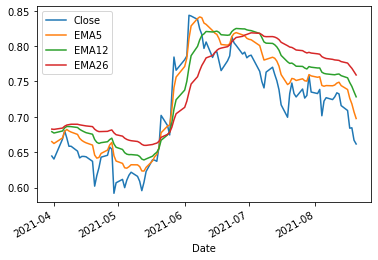

In [26]:
prices_sc = df_data_scaled.Close[-100:]
prices_sc.plot()
df_data_scaled.EMA5[-100:].plot()
df_data_scaled.EMA12[-100:].plot()
df_data_scaled.EMA26[-100:].plot()
plt.legend()

In [33]:
def part_data_train_test(df_data_scaled, test_size = 200):
    df_X_input = df_data_scaled.drop(columns=['Short_Gain', 'Long_Gain','Rating'])
    X_train = df_X_input[:-test_size].values
    X_test = df_X_input[-test_size:].values

    df_y_input = df_data_scaled['Long_Gain']
    y_train = df_y_input[:-test_size].values
    y_test = df_y_input[-test_size:].values

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = part_data_train_test(df_data_scaled)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# def part_data(df_data_scaled, test_size = 1):
#     df_X_input = df_data_scaled.drop(columns=['Short_Gain', 'Long_Gain','Rating'])
#     X= df_X_input.values

#     df_y_input = df_data_scaled['Long_Gain']
#     y = df_y_input.values

#     return X,y

# X,y = part_data(df_data_scaled)
# print(X.shape, y.shape)

(12214, 19) (200, 19) (12214,) (200,)


In [34]:
from keras.layers import Dense
from keras.models import Sequential

def NN_model():
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

model = NN_model()

In [39]:
from keras.callbacks import EarlyStopping
np.random.seed(1)

callback = EarlyStopping(monitor='mae', patience=3, restore_best_weights=True, verbose=1)

model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[callback])

Epoch 1/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0273
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0273
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0273
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0270
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0271
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0271
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0266
Epoch 8/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0267
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0264
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0265
Epoch 11/100
48/48 [==============================] - 0s 2m

In [36]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0481


[0.003356465371325612, 0.04814675450325012]

<AxesSubplot:>

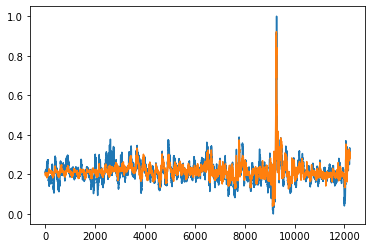

In [37]:
y_train_pred = model.predict(X_train)

sns.lineplot(x=np.arange(0,len(y_train)), y= y_train)
sns.lineplot(x=np.arange(0,len(y_train_pred)), y= y_train_pred[:,0])

<AxesSubplot:>

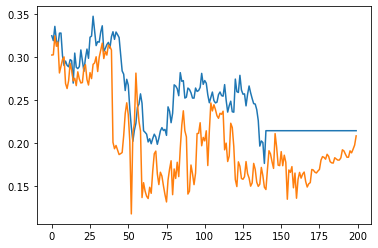

In [38]:
y_test_pred = model.predict(X_test)

sns.lineplot(x=np.arange(0,len(y_test)), y= y_test)
sns.lineplot(x=np.arange(0,len(y_test_pred)), y= y_test_pred[:,0])